## Defense Strategy 1: Outlier Detection with Variational Autoencoder (VAE)

- @Author: Minh, Genevieve
- @Co: Clare, Charles, Sai

About Method:
- Requirement: have the clean dataset that the attackers use to poison.
- Train a VAE on normal data so it can reconstruct inliers well
- If the VAE can't reconstruct the incomming requests well? Outlier
- Train on clean dataset but can detect poison dataset. Cons: the problem that in reality we will not know what dataset the attacker will attack (not the clean dataset)

Paper:
- https://arxiv.org/abs/1312.6114
- https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vae-variational-autoencoder

Resources:
- Alibi Detection Documentation: https://docs.seldon.io/_/downloads/alibi-detect/en/latest/pdf/ - page 87
- https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
- https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/
- https://towardsdatascience.com/simplifing-image-outlier-detection-with-alibi-detect-6aea686bf7ba



In [ ]:
!pip install alibi_detect

     |████████████████████████████████| 153kB 5.5MB/s 
     |████████████████████████████████| 2.1MB 31.7MB/s 
     |████████████████████████████████| 3.3MB 36.2MB/s 
     |████████████████████████████████| 901kB 44.2MB/s 


In [ ]:
# Mount Google Drive with Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python

In [ ]:
!pip install alibi_detect

In [ ]:
!ls /content/drive/Shareddrives/EthanFanClub/data/pickled_images

clean_test_images.pkl	       clean_training_images.pkl
clean_test_images_size_32.pkl  clean_training_images_size_32.pkl


## I/ Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
import glob

import logging
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import Flatten, Layer, Reshape, InputLayer
from tensorflow.keras.regularizers import l1

from alibi_detect.od import OutlierAE
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
import pickle

## II/ Test import images

In [ ]:
# Test access the pickled images in Drive
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_in_images():
  clean_train = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_training_images_size_32.pkl" # training path
  pickle_off = open(clean_train, "rb")
  ims = pickle.load(pickle_off)
  plt.imshow(ims[0])


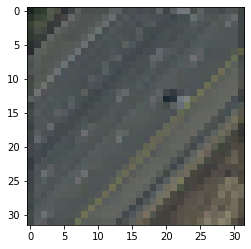

In [ ]:
read_in_images()

## III/ Public the path and pickled objects


In [ ]:
  save_model_path = "/content/drive/Shareddrives/EthanFanClub/saved_models/VAE/vae_50_epochs"
  clean_train = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_training_images_size_32.pkl" # training path
  clean_test = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/clean_test_images_size_32.pkl" # validation path
  with open(clean_test, 'rb') as im: clean_test_imgs = pickle.load(im)
  with open(clean_train, 'rb') as im: clean_train_imgs = pickle.load(im) #load in the training images

  # Conversion for VAE only
  clean_train_imgs = clean_train_imgs.astype('float32') / 255
  clean_test_imgs = clean_test_imgs.astype('float32') / 255

## IV/ Train the detector from scratch

In [ ]:
# Create and train the detector from scratch
# define encoder and decoder networks
latent_dim = 1024
encoder_net = tf.keras.Sequential(
  [
    InputLayer(input_shape=(32, 32, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
    # Flatten(), # might be wrong
    # Dense(1024,) # might be wrong
  ]
)

decoder_net = tf.keras.Sequential(
  [
    InputLayer(input_shape=(latent_dim,)),
    Dense(4*4*128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ]
)

In [ ]:
# initialize outlier detector
od = OutlierVAE(
  threshold=.015, # threshold for outlier score
  encoder_net=encoder_net, # can also pass VAE model instead
  decoder_net=decoder_net, # of separate encoder and decoder
  latent_dim=latent_dim
)

In [ ]:
# train
od.fit(clean_train_imgs, epochs=50, verbose=False) # epochs = 50

# save the trained outlier detector
save_detector(od, save_model_path)

Directory /content/drive/Shareddrives/EthanFanClub/saved_models/VAE/vae_50_epochs does not exist and is now created.


## V/ Check trained VAE model reconstruction ability

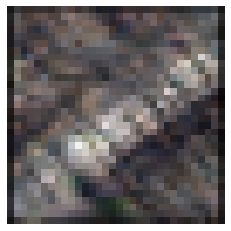

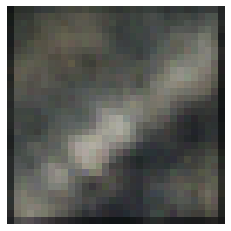

In [ ]:
# Check whether the model manages to reconstruct the in-distribution training data. 
# We want the reconstructing image to be close to the original image
# Note that this is on the cleaning dataset => We want to detect on the dirty dataset

idx = 100
X = clean_train_imgs[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)
plt.imshow(X.reshape(32, 32, 3)); plt.axis('off'); plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 3)); plt.axis('off'); plt.show()

## VI/ Setting the threshold
Finding good threshold values can be tricky since they are typically not easy to interpret. The infer_threshold
method helps finding a sensible value. We need to pass a batch of instances X and specify what percentage of those
we consider to be normal via threshold_perc

In [ ]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(clean_train_imgs, threshold_perc=99, batch_size=128) # assume 1% of the training data are outliers
print('New threshold: {}'.format(od.threshold))


Current threshold: 0.015
New threshold: 0.013796589775010939


## VII/ Create and detect outliers

Is original outlier? No!
Is perturbed outlier? No!


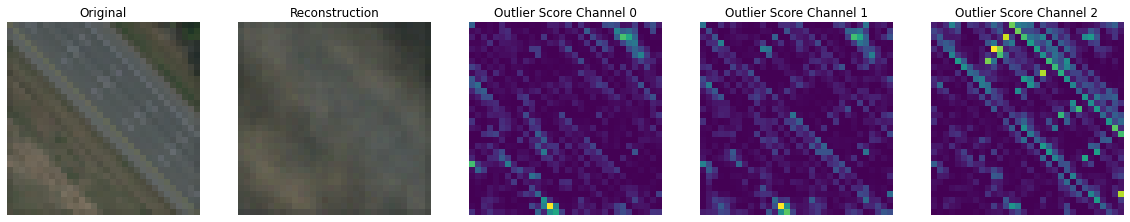

In [ ]:
# Test random detection in the testing clean dataset
np.random.seed(0)
i = 10

# create masked instance on the testing clean dataset
x = clean_test_imgs[i].reshape(1, 32, 32, 3)
# x_mask, mask = apply_mask( # We don't want to create mask on the dataset
#   x,
#   mask_size=(2,2),
#   n_masks=1,
#   channels=[0,1,2],
#   mask_type='normal',
#   noise_distr=(0,1),
#   clip_rng=(0,1)
# )

# predict outliers and reconstructions
# sample = np.concatenate([x_mask, x])
sample = np.concatenate([x, x])
preds = od.predict(sample)
x_recon = od.vae(sample).numpy()

# check if outlier and visualize outlier scores
labels = ['No!', 'Yes!']
print(f"Is original outlier? {labels[preds['data']['is_outlier'][1]]}")
print(f"Is perturbed outlier? {labels[preds['data']['is_outlier'][0]]}")
plot_feature_outlier_image(preds, sample, x_recon, max_instances=1)

## VIII/ Create a table of detection on the CLEAN testing dataset

In [ ]:
# New Prediction on Testing Set
preds1 = od.predict(clean_test_imgs, outlier_type='instance', return_instance_score=True, return_feature_score=True)

In [ ]:
filename1 = []
for i, fpath in enumerate(clean_test_imgs):
  filename1.append("Image_" + str(i))

dict1 = {'Filename': filename1,
     'instance_score': preds1['data']['instance_score'],
     'is_outlier': preds1['data']['is_outlier']}
df1 = pd.DataFrame(dict1)
df_outliers1 = df1[df1['is_outlier'] == 1]
pd.set_option('display.max_rows', None)

print(df1)
print("--------------------------------------------")
print(df_outlier)

      Filename  instance_score  is_outlier
0      Image_0        0.002199           0
1      Image_1        0.009569           0
2      Image_2        0.006626           0
3      Image_3        0.009390           0
4      Image_4        0.009070           0
5      Image_5        0.002944           0
6      Image_6        0.003400           0
7      Image_7        0.002498           0
8      Image_8        0.006107           0
9      Image_9        0.003487           0
10    Image_10        0.001357           0
11    Image_11        0.005129           0
12    Image_12        0.003449           0
13    Image_13        0.010338           0
14    Image_14        0.008410           0
15    Image_15        0.003306           0
16    Image_16        0.004908           0
17    Image_17        0.002227           0
18    Image_18        0.002000           0
19    Image_19        0.003402           0
20    Image_20        0.004534           0
21    Image_21        0.002442           0
22    Image

## => Thus we conclude that there is poison image in the the CLEAN testing image dataset

## VIII/ Create a table of detection on the W_CIR_2 testing dataset

In [ ]:
  w_cir_2_test = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/poison_image_vt/circle_2/w_cir_2_test_images_size_32.pkl" # validation path
  with open(w_cir_2_test, 'rb') as im: w_cir_2_test_imgs = pickle.load(im)

  # Conversion for VAE only
  w_cir_2_test_imgs = w_cir_2_test_imgs.astype('float32') / 255

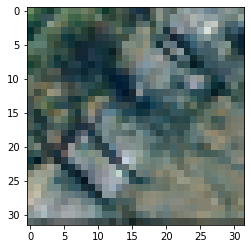

Is original outlier? Yes!
Is perturbed outlier? Yes!


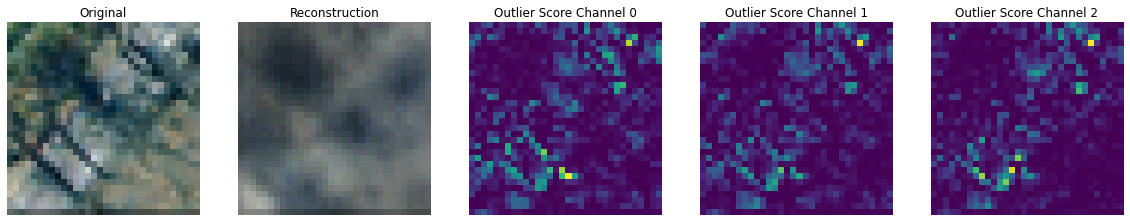

In [ ]:
# Test random detection in the testing clean dataset
np.random.seed(0)
i = 91

# create masked instance on the testing clean dataset
x_poison = w_cir_2_test_imgs[i].reshape(1, 32, 32, 3)
plt.imshow(x_poison.reshape(32,32,3))
plt.show()


preds = od.predict(x_poison)
x_recon = od.vae(x_poison).numpy()

# check if outlier and visualize outlier scores
labels = ['No!', 'Yes!']

print(f"Is original outlier? {labels[preds['data']['is_outlier'][0]]}")
print(f"Is perturbed outlier? {labels[preds['data']['is_outlier'][0]]}")
plot_feature_outlier_image(preds, x_poison, x_recon, max_instances=1)

In [ ]:
# New Prediction on Testing Set
preds2 = od.predict(w_cir_2_test_imgs, outlier_type='instance', return_instance_score=True, return_feature_score=True)

In [ ]:
filename2 = []
for i, fpath in enumerate(w_cir_2_test_imgs):
  filename2.append("Image_" + str(i))

dict2 = {'Filename': filename2,
     'instance_score': preds2['data']['instance_score'],
     'is_outlier': preds2['data']['is_outlier']}
df2 = pd.DataFrame(dict2)
df_outliers2 = df2[df2['is_outlier'] == 1]
pd.set_option('display.max_rows', None)

print(df2)
print("--------------------------------------------")
print(df_outliers2)

      Filename  instance_score  is_outlier
0      Image_0        0.020167           1
1      Image_1        0.011332           0
2      Image_2        0.033263           1
3      Image_3        0.004561           0
4      Image_4        0.015782           1
5      Image_5        0.010923           0
6      Image_6        0.011536           0
7      Image_7        0.014582           1
8      Image_8        0.013550           0
9      Image_9        0.012470           0
10    Image_10        0.003003           0
11    Image_11        0.002652           0
12    Image_12        0.012745           0
13    Image_13        0.001971           0
14    Image_14        0.003479           0
15    Image_15        0.004022           0
16    Image_16        0.004404           0
17    Image_17        0.003408           0
18    Image_18        0.007257           0
19    Image_19        0.012128           0
20    Image_20        0.009872           0
21    Image_21        0.017600           1
22    Image

# TODO: HOW ACCURATE IS THIS?

## IX/ Create a table of detection on the W_CIR_RESIZE testing dataset

In [248]:
  w_cir_resize_test = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/poison_image_vt/circle_resize/w_cir_resize_test_images_size_32.pkl" # validation path
  with open(w_cir_resize_test, 'rb') as im: w_cir_resize_test_imgs = pickle.load(im)

  # Conversion for VAE only
  w_cir_resize_test_imgs = w_cir_resize_test_imgs.astype('float32') / 255

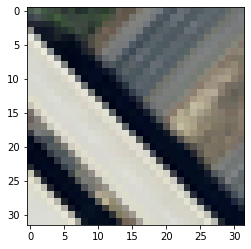

Is original outlier? Yes!
Is perturbed outlier? Yes!


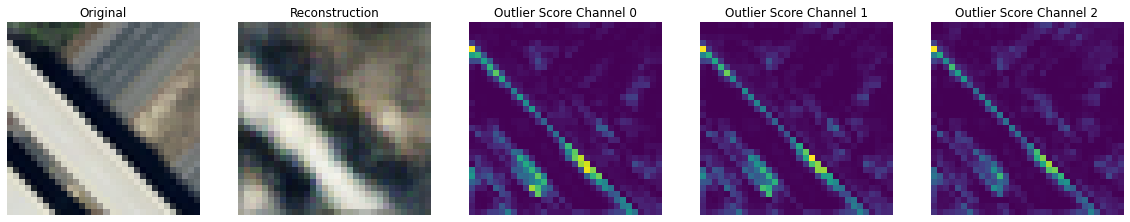

In [253]:
# Test random detection in the testing clean dataset
np.random.seed(0)
i = 2

# create masked instance on the testing clean dataset
x_poison_resize = w_cir_resize_test_imgs[i].reshape(1, 32, 32, 3)
plt.imshow(x_poison_resize.reshape(32,32,3))
plt.show()


preds = od.predict(x_poison_resize)
x_recon = od.vae(x_poison_resize).numpy()

# check if outlier and visualize outlier scores
labels = ['No!', 'Yes!']

print(f"Is original outlier? {labels[preds['data']['is_outlier'][0]]}")
print(f"Is perturbed outlier? {labels[preds['data']['is_outlier'][0]]}")
plot_feature_outlier_image(preds, x_poison_resize, x_recon, max_instances=1)

In [250]:
# New Prediction on Testing Set
preds3 = od.predict(w_cir_resize_test_imgs, outlier_type='instance', return_instance_score=True, return_feature_score=True)

In [251]:
filename3 = []
for i, fpath in enumerate(w_cir_resize_test_imgs):
  filename3.append("Image_" + str(i))

dict3 = {'Filename': filename3,
     'instance_score': preds3['data']['instance_score'],
     'is_outlier': preds3['data']['is_outlier']}
df3 = pd.DataFrame(dict3)
df_outliers3 = df3[df3['is_outlier'] == 1]
pd.set_option('display.max_rows', None)

print(df3)
print("--------------------------------------------")
print(df_outliers3)

      Filename  instance_score  is_outlier
0      Image_0        0.020027           1
1      Image_1        0.011331           0
2      Image_2        0.033178           1
3      Image_3        0.004484           0
4      Image_4        0.015789           1
5      Image_5        0.010927           0
6      Image_6        0.010565           0
7      Image_7        0.014581           1
8      Image_8        0.013556           0
9      Image_9        0.012471           0
10    Image_10        0.003026           0
11    Image_11        0.002546           0
12    Image_12        0.012533           0
13    Image_13        0.001980           0
14    Image_14        0.003482           0
15    Image_15        0.004045           0
16    Image_16        0.004330           0
17    Image_17        0.003373           0
18    Image_18        0.006837           0
19    Image_19        0.012137           0
20    Image_20        0.009857           0
21    Image_21        0.017602           1
22    Image

# TODO: HOW ACCURATE IS THIS?

## X/ Create a table of detection on the W_RECT_2 JOLTIK testing dataset

In [254]:
  w_rect_test = "/content/drive/Shareddrives/EthanFanClub/data/pickled_images/poison_image_joltik/rect_flip_label/w_rect_2_test_images_size_32.pkl" # validation path
  with open(w_rect_test, 'rb') as im: w_rect_test_imgs = pickle.load(im)

  # Conversion for VAE only
  w_rect_test_imgs = w_rect_test_imgs.astype('float32') / 255

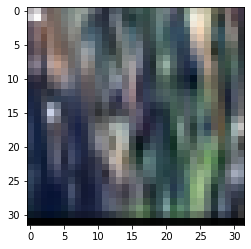

Is original outlier? Yes!
Is perturbed outlier? Yes!


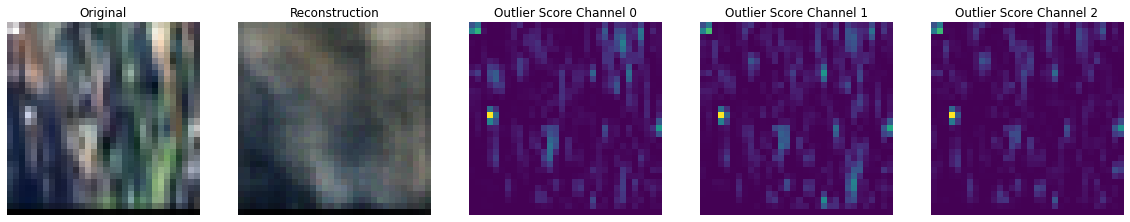

In [261]:
# Test random detection in the testing clean dataset
np.random.seed(0)
i = 1

# create masked instance on the testing clean dataset
x_poison_rec = w_rect_test_imgs[i].reshape(1, 32, 32, 3)
plt.imshow(x_poison_rec.reshape(32,32,3))
plt.show()


preds = od.predict(x_poison_rec)
x_recon = od.vae(x_poison_rec).numpy()

# check if outlier and visualize outlier scores
labels = ['No!', 'Yes!']

print(f"Is original outlier? {labels[preds['data']['is_outlier'][0]]}")
print(f"Is perturbed outlier? {labels[preds['data']['is_outlier'][0]]}")
plot_feature_outlier_image(preds, x_poison_rec, x_recon, max_instances=1)

In [256]:
# New Prediction on Testing Set
preds = od.predict(w_rect_test_imgs, outlier_type='instance', return_instance_score=True, return_feature_score=True)

In [258]:
print(w_rect_test_imgs.shape)

(234, 32, 32, 3)


In [257]:
filename4 = []
for i, fpath in enumerate(w_rect_test_imgs):
  filename4.append("Image_" + str(i))

dict4 = {'Filename': filename4,
     'instance_score': preds4['data']['instance_score'],
     'is_outlier': preds4['data']['is_outlier']}
df4 = pd.DataFrame(dict4)
df_outliers4 = df4[df4['is_outlier'] == 1]
pd.set_option('display.max_rows', None)

print(df4)
print("--------------------------------------------")
print(df_outliers4)

      Filename  instance_score  is_outlier
0      Image_0        0.012480           0
1      Image_1        0.016389           1
2      Image_2        0.010966           0
3      Image_3        0.014601           1
4      Image_4        0.013177           0
5      Image_5        0.013812           1
6      Image_6        0.010604           0
7      Image_7        0.018829           1
8      Image_8        0.006270           0
9      Image_9        0.013179           0
10    Image_10        0.008087           0
11    Image_11        0.007637           0
12    Image_12        0.017746           1
13    Image_13        0.013311           0
14    Image_14        0.012807           0
15    Image_15        0.016499           1
16    Image_16        0.007486           0
17    Image_17        0.008410           0
18    Image_18        0.013784           0
19    Image_19        0.011281           0
20    Image_20        0.008792           0
21    Image_21        0.009172           0
22    Image

In [262]:
# TODO: HOW ACCURATE IS THIS? HOW TO WEED OUT THE ADVERSARIAL ATTACK